In [14]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import sys
import scipy
from scipy.spatial.distance import pdist, squareform
from scipy import optimize
from networkx.algorithms.community import greedy_modularity_communities

RESULT_PATH = '../results/'

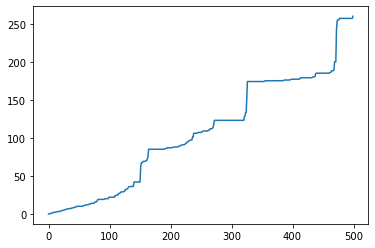

In [2]:
def load_graph_and_signals(path1, path2):
    return np.load(path1), np.load(path2)


A, signals = load_graph_and_signals('A_apr24_new_20.npy', 'probabilities_1.npy')

I = np.identity(500)

d_seq = [np.sum(row) for row in A]

D = I*d_seq

L = D - A

eigs, evecs = np.linalg.eigh(L)

plt.plot(eigs)
plt.show()
#print(eigs)
H_l = np.matmul(np.linalg.inv(I+0.5*L), signals[1:501,:])
#print(H_l)
B = np.load('B_apr24_new_20.npy')

In [15]:
def poisson(k, a, lamb):
    return a * (lamb**k/scipy.special.factorial(k)) * np.exp(-lamb)

def poisson_approx(k, a, lamb):
    return a*np.exp(-(k-lamb)**2/(2*lamb))

def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def power(x,a,gamma,k0):
    return a* x**(gamma-1) * x**(-gamma)

def graph_exploratory_analysis(graph,adjacency, graph_type="model_fitting"):
    # Basic stats
    print('Number of nodes: {}, Number of edges: {}'. format(graph.number_of_nodes(), graph.number_of_edges()))
    # Number of connected components
    print('Number of connected components: {}'. format(nx.number_connected_components(graph)))
    # Diameter
    if nx.number_connected_components(graph) == 1:
        print('Diameter of the graph: {}'.format(nx.diameter(graph)))
    # Clustering coefficient
    print('Clustering coefficient: {}'.format(nx.average_clustering(graph)))
    # Degree distribution 
    degrees = [d for n,d in graph.degree()]
    
    plt.figure(figsize = [3.8,3.5])
    entries, bin_edges, patches = plt.hist(degrees, bins = 21, color = 'xkcd:dark gray', label = 'Degrees dist.')
    bin_middles = 0.5*(bin_edges[1:] + bin_edges[:-1])
    mean = np.mean(degrees) #sum(bin_middles * entries) / len(bin_middles)
    sigma = np.var(degrees) #  sum(entries*(bin_middles-mean)**2)/ len(bin_middles)
    
    popt_gauss,pcov_gauss = scipy.optimize.curve_fit(gaus, bin_middles, entries, p0=[1,0,1],maxfev = 5000)
    popt_poiss2,pcov_poiss2 = scipy.optimize.curve_fit(poisson_approx, bin_middles, entries, p0=[1,0],maxfev =5000)
  #  popt_power,pcov_power = scipy.optimize.curve_fit(power, bin_middles[np.argmax(entries):], entries[np.argmax(entries):], p0=[np.max(entries), mean,10])
    
    x_plot = np.linspace(np.min(bin_edges), np.max(bin_edges),100)
    plt.plot(x_plot,gaus(x_plot,*popt_gauss),'-',c = 'xkcd:orange', label='Normal dist. fit')
    plt.plot(x_plot,poisson_approx(x_plot,*popt_poiss2),'-',c = 'xkcd:green', label='Poisson dist. fit')
    plt.legend()
   # plt.title("Degree distribution")
    plt.xlabel("Degree")
    plt.ylabel("# of nodes")
    plt.xlim(np.min(bin_edges), np.max(bin_edges))
    plt.ylim(top = 1.4 * np.max(entries))
    plt.tight_layout()
    plt.savefig(f'{RESULT_PATH}{graph_type}_graph_degree_distribution.png', dpi = 300)
    plt.show()
    
    plt.loglog(bin_middles, entries,'o')
    plt.loglog(x_plot,gaus(x_plot,*popt_gauss),'-',c='xkcd:orange',label='fit')
    plt.title("Degree distribution Log-Log")
    plt.xlabel("Degree")
    plt.ylabel("# of nodes")
    plt.savefig(RESULT_PATH+'Russo_Ukrainian_Crisis_'+graph_type+'_graph_degree_distribution_loglog.png')
    plt.show()
    
    print(f'mean degree', np.mean(degrees))
    print(f'2nd moment of degrees:', np.sum(np.power(degrees,2)) / len(degrees))
    
    # Centrality
    centrality = list(nx.degree_centrality(graph).values())
    print('Mean degree centrality of nodes: {}'.format(np.mean(centrality)))
    
    # largest connected component
    Gc = max((graph.subgraph(c) for c in nx.connected_components(graph)), key=len)
    print(f'Diameter of largest connected component: {nx.diameter(Gc)}')
    
    print(f'Average clustering: {nx.average_clustering(graph)}')
      

    

In [16]:
#adjacency matrix sample
sample = A[:100,:100]
graph_sample = nx.from_numpy_matrix(sample, parallel_edges=False)

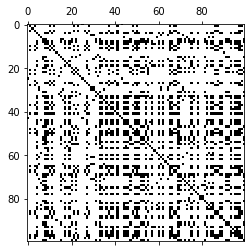

In [17]:
plt.spy(sample)
plt.show()

Number of nodes: 100, Number of edges: 1178
Number of connected components: 8
Clustering coefficient: 0.8150055783590759


C:\Users\Chat\AppData\Local\Temp/ipykernel_25588/2621601115.py:5: RuntimeWarning: divide by zero encountered in true_divide
  return a*np.exp(-(k-lamb)**2/(2*lamb))
C:\Users\Chat\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\Chat\AppData\Local\Temp/ipykernel_25588/2621601115.py:5: RuntimeWarning: divide by zero encountered in true_divide
  return a*np.exp(-(k-lamb)**2/(2*lamb))


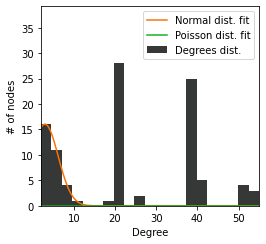

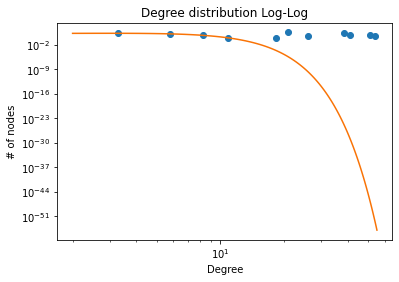

mean degree 23.56
2nd moment of degrees: 797.78
Mean degree centrality of nodes: 0.23797979797979799
Diameter of largest connected component: 8
Average clustering: 0.8150055783590759


In [18]:
graph_exploratory_analysis(graph_sample, sample,'Russo_Ukrainian_Crisis_sample')

Number of nodes: 500, Number of edges: 27359
Number of connected components: 3
Clustering coefficient: 0.8804220493850464


C:\Users\Chat\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\Chat\AppData\Local\Temp/ipykernel_25588/2621601115.py:5: RuntimeWarning: divide by zero encountered in true_divide
  return a*np.exp(-(k-lamb)**2/(2*lamb))
C:\Users\Chat\AppData\Local\Temp/ipykernel_25588/2621601115.py:5: RuntimeWarning: divide by zero encountered in true_divide
  return a*np.exp(-(k-lamb)**2/(2*lamb))


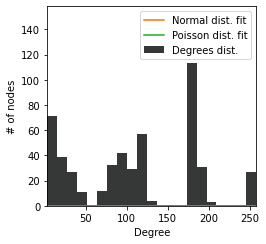

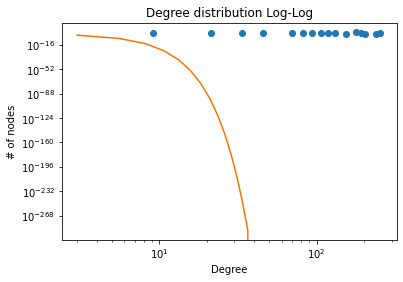

mean degree 109.436
2nd moment of degrees: 17217.184
Mean degree centrality of nodes: 0.21931062124248496


In [ ]:
graph = nx.from_numpy_matrix(A, parallel_edges=False)
graph_exploratory_analysis(graph, A,'Russo_Ukrainian_Crisis')